In [104]:
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [105]:

class LinearHT:

    def __init__(self, ip, aSteps, rSteps):
        self.ip = ip # reference to original image
        self.xCtr = len(ip[0]) // 2 # x-coordinate of image center
        self.yCtr = len(ip) // 2 # y-coordinate of image center
        self.nAng = aSteps # number of steps for angle
        self.dAng = math.pi / self.nAng # stepsize of angle
        self.nRad = rSteps # number of steps for radius
        self.rMax = math.sqrt(self.xCtr ** 2 + self.yCtr ** 2)
        self.dRad = (2*self.rMax) / self.nRad # stepsize of radius
        self.houghArray = np.zeros((self.nAng, self.nRad), dtype=np.float32)
        self.px_count = 0
        self.fillHoughAccumulator()
        
    
    def fillHoughAccumulator(self):
        for v in range(len(self.ip)):
            for u in range(len(self.ip[0])):
                if self.ip[v][u] == 0:
                    self.px_count += 1
                    self.doPixel(u, v)
    
    def doPixel(self, u, v):
        x = u - self.xCtr
        y = v - self.yCtr
        for a in range(self.nAng):
            theta = self.dAng * a
            r = int(round((x * math.cos(theta) + y * math.sin(theta)) / self.dRad) + self.nRad // 2)
            if r >= 0 and r < self.nRad:
                self.houghArray[r][a] += 1

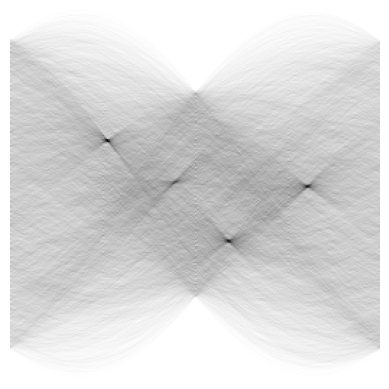

In [106]:
img = cv2.imread("noisy-lines.tif", cv2.IMREAD_GRAYSCALE)

lines = LinearHT(img, 256, 256)

show = np.array(255 * (lines.houghArray / np.max(lines.houghArray)), dtype=np.uint8)

invert = np.vectorize(lambda x: 255 - x)

show = invert(show)

plt.imshow(show, cmap='gray')
plt.axis('off')
plt.show()

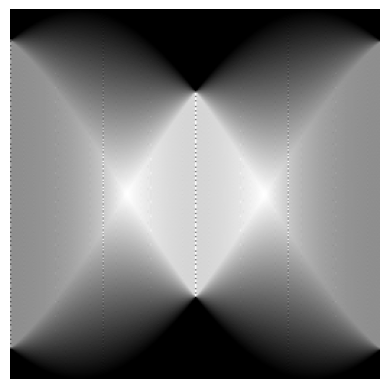

In [107]:

class Bias:

    def __init__(self, ip, aSteps, rSteps):
        self.ip = ip # reference to original image
        self.xCtr = len(ip[0]) // 2 # x-coordinate of image center
        self.yCtr = len(ip) // 2 # y-coordinate of image center
        self.nAng = aSteps # number of steps for angle
        self.dAng = math.pi / self.nAng # stepsize of angle
        self.nRad = rSteps # number of steps for radius
        self.rMax = math.sqrt(self.xCtr ** 2 + self.yCtr ** 2)
        self.dRad = (2*self.rMax) / self.nRad # stepsize of radius
        self.houghArray = np.zeros((self.nAng, self.nRad), dtype=np.float32)
        self.fillHoughAccumulator()
    
    def fillHoughAccumulator(self):
        for v in range(len(self.ip)):
            for u in range(len(self.ip[0])):
                self.doPixel(u, v)
    
    def doPixel(self, u, v):
        x = u - self.xCtr
        y = v - self.yCtr
        for a in range(self.nAng):
            theta = self.dAng * a
            r = int(round((x * math.cos(theta) + y * math.sin(theta)) / self.dRad) + self.nRad // 2)
            if r >= 0 and r < self.nRad:
                self.houghArray[r][a] += 1


bias = Bias(img, 256, 256)

show = np.array(255 * (bias.houghArray / np.max(bias.houghArray)), dtype=np.uint8)

invert = np.vectorize(lambda x: 255 - x)

#show = invert(show)

plt.imshow(show, cmap='gray')
plt.axis('off')
plt.show()

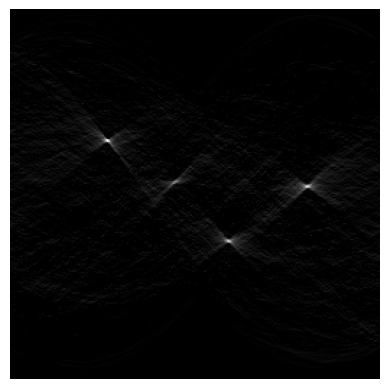

In [108]:
lines.houghArray -= bias.houghArray * lines.px_count / (len(img)*len(img[0]))
accumulator = [[0 if y < 0 else y for y in row] for row in lines.houghArray]


plt.imshow(accumulator, cmap='gray')
plt.axis('off')
plt.show()

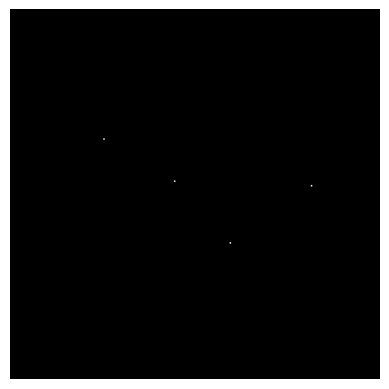

In [111]:
# lokale Maxima suchen mit Filter: Ist Mittelpunkt heller als alle 8 Nachbarn
threshold = 50

#test a dynamic treshold
#dyn_threshold = int(int(max(accumulator)) * 0.5)
#print(dyn_threshold)
local_maxima = np.zeros((256 - 10, 256 - 10))
for y in range(5, len(accumulator) - 5):
    for x in range(5, len(accumulator[0]) - 5):
        if accumulator[y][x] >= threshold:
            isLocalMax = True
            for width in range(x - 5, x + 6):
                for height in range(y - 5, y + 6):
                    if accumulator[y][x] < accumulator[height][width]:
                        isLocalMax = False
                        break
                if not isLocalMax:
                    break
            if isLocalMax:
                local_maxima[y - 5][x - 5] = 255
            else:
                local_maxima[y - 5][x - 5] = 0

plt.imshow(local_maxima, cmap='gray')
plt.axis('off')
plt.show()
                    

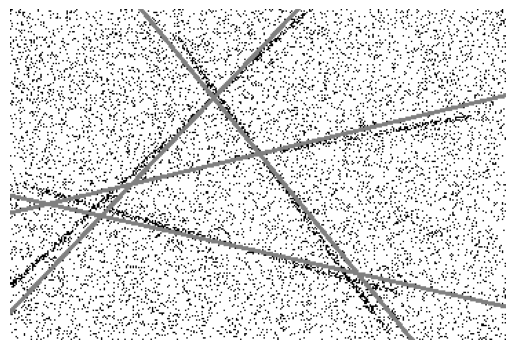

In [97]:
#lines im Originalbild darstellen
ip = img # reference to original image
xCtr = len(ip[0]) // 2 # x-coordinate of image center
yCtr = len(ip) // 2 # y-coordinate of image center
nRad = 256 # number of steps for radius
rMax = math.sqrt(xCtr ** 2 + yCtr ** 2)
dRad = (2 * rMax) / nRad # stepsize of radius

for y, x in zip(*np.where(local_maxima == 255)):
    angle = x * np.pi / 256
    #radius = (y + 5 - 128) * (2 * lines.rMax / 256)
    index_y = y + 5
    radius = (index_y - nRad // 2) * dRad
    a = math.cos(angle)
    b = math.sin(angle)
    x0 = a * radius + lines.xCtr
    y0 = b * radius + lines.yCtr
    pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * a))
    pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * a))
    cv2.line(img, pt1, pt2, 128, 2)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
